In [45]:
import os
import numpy as np
import pandas as pd
import xarray
import rioxarray as rio
import geopandas as gdp
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import netCDF4 as nc
import sys

<xarray.Dataset>
Dimensions:             (lon: 102, bnds: 2, lat: 75)
Coordinates:
  * lon                 (lon) float64 -73.87 -73.83 -73.8 ... -70.21 -70.17
  * lat                 (lat) float64 -12.37 -12.4 -12.44 ... -14.97 -15.0
Dimensions without coordinates: bnds
Data variables:
    lon_bnds            (lon, bnds) float64 ...
    lat_bnds            (lat, bnds) float64 ...
    latitude_longitude  int32 ...
    land_frac           (lat, lon) float64 ...

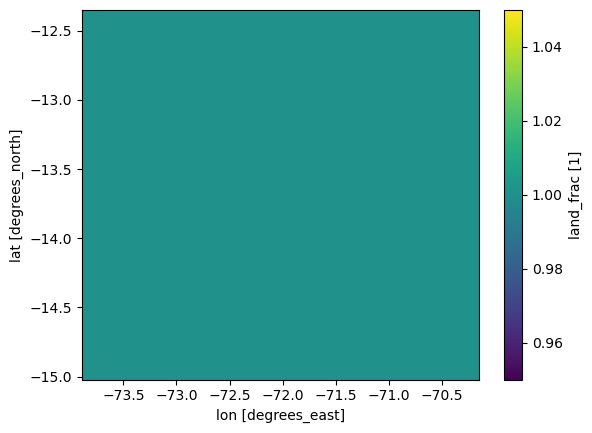

In [33]:
land_frac = xarray.open_dataset("/home/clara/rahu_data/netcdf/jules_land_frac_ESA_rahu.nc")
land_frac['land_frac'].plot()
land_frac 
# This file needs to be changed to lat from -15 to -12.37 to match the input datasets that JULES reads

In [35]:
# Create new full grid land frac .nc file with reversed lat axis
land_frac_new = land_frac.reindex(lat=list(reversed(land_frac.lat)))
#land_frac_new['land_frac'].plot()

# Create new netcdf
land_frac_new.to_netcdf("/home/clara/rahu_data/netcdf/jules_land_frac_ESA_rahu_clipped.nc", 'w', format="NETCDF4")

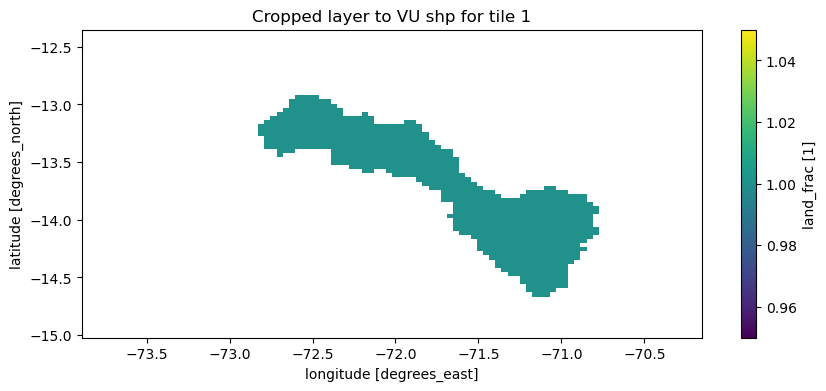

<xarray.DataArray 'land_frac' (lat: 75, lon: 102)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 -73.87 -73.83 -73.8 -73.76 ... -70.24 -70.21 -70.17
  * lat      (lat) float64 -15.0 -14.97 -14.93 -14.9 ... -12.44 -12.4 -12.37
Attributes:
    units:          1
    standard_name:  land_frac
    grid_mapping:   latitude_longitude

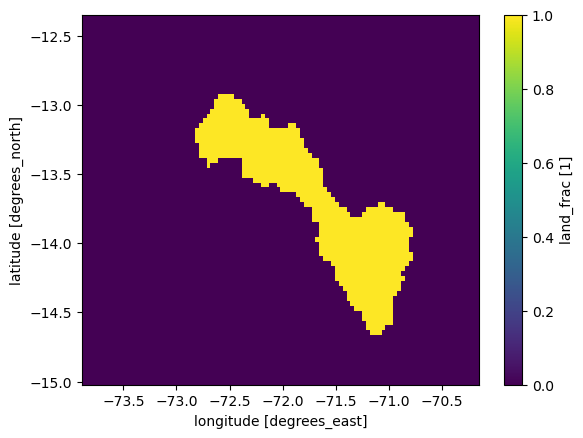

In [36]:
land_frac_new.rio.write_crs(4326, inplace=True)
shpfile = gdp.read_file("/home/clara/rahu_data/VUB_studies/VUB_full/cuenca_vilcanota_final.shp")
shpfile = shpfile.to_crs(epsg=4326)

land_frac_neww = land_frac_new['land_frac']
clipped = land_frac_neww.rio.clip(shpfile.geometry.apply(mapping), shpfile.crs, all_touched=True, drop=False) # clip raster for any gridcell where geometry touches.
# all_touched (bool, optional) – If True, all pixels touched by geometries will be burned in. If false, only pixels whose center is within the polygon or that are selected by Bresenham’s line algorithm will be burned in.
f, ax = plt.subplots(figsize=(10,4))
clipped.plot(ax=ax)
ax.set(title="Cropped layer to VU shp for tile 1")
plt.show()

clipped = clipped.fillna(0)
clipped = clipped.drop_vars("latitude_longitude")
clipped.plot()

clipped

In [37]:
# Now .nc file with new land mask
dset=nc.Dataset("/home/clara/rahu_data/netcdf/jules_land_frac_ESA_rahu_clipped.nc", 'r+')
dset['land_frac'][:]=clipped
dset.close()